# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch Normalization as a tool to more efficiently optimize deep networks.
  

In [61]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Affine layer: foward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [63]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape) # 240
weight_size = output_dim * np.prod(input_shape)# 360

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape) # (2,4,5,6)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim) # (120,3)
b = np.linspace(-0.3, 0.1, num=output_dim) #(3,)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [64]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# ReLU layer: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [65]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 5e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU layer: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [66]:
np.random.seed(231)
x = np.random.randn(10, 8)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 3e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.275627513767873e-12


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [67]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Testing affine_relu_forward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward:
dx error:  2.299579177309368e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax and SVM
You implemented these loss functions in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `cs231n/layers.py`.

You can make sure that the implementations are correct by running the following:

In [68]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be 1e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.384673161989355e-09


# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [69]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.12e-10
b1 relative error: 9.83e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 2.85e-08
b1 relative error: 1.56e-08
b2 relative error: 7.76e-10


# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [70]:
model = TwoLayerNet()
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################

learning_rate = 1e-4

solver = Solver(model, data, print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                })
solver.train()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 39200) loss: 2.304751
(Epoch 0 / 20) train acc: 0.084000; val_acc: 0.067000
(Iteration 11 / 39200) loss: 2.303648
(Iteration 21 / 39200) loss: 2.299642
(Iteration 31 / 39200) loss: 2.287878
(Iteration 41 / 39200) loss: 2.282946
(Iteration 51 / 39200) loss: 2.290250
(Iteration 61 / 39200) loss: 2.257968
(Iteration 71 / 39200) loss: 2.282584
(Iteration 81 / 39200) loss: 2.259024
(Iteration 91 / 39200) loss: 2.251850
(Iteration 101 / 39200) loss: 2.249544
(Iteration 111 / 39200) loss: 2.255538
(Iteration 121 / 39200) loss: 2.243551
(Iteration 131 / 39200) loss: 2.192832
(Iteration 141 / 39200) loss: 2.263600
(Iteration 151 / 39200) loss: 2.237593
(Iteration 161 / 39200) loss: 2.162531
(Iteration 171 / 39200) loss: 2.089980
(Iteration 181 / 39200) loss: 2.052813
(Iteration 191 / 39200) loss: 2.136751
(Iteration 201 / 39200) loss: 2.217958
(Iteration 211 / 39200) loss: 2.031456
(Iteration 221 / 39200) loss: 1.977774
(Iteration 231 / 39200) loss: 2.166749
(Iteration 241 / 3920

(Iteration 2051 / 39200) loss: 1.664408
(Iteration 2061 / 39200) loss: 1.897966
(Iteration 2071 / 39200) loss: 1.722676
(Iteration 2081 / 39200) loss: 1.674211
(Iteration 2091 / 39200) loss: 1.812720
(Iteration 2101 / 39200) loss: 1.443076
(Iteration 2111 / 39200) loss: 1.565276
(Iteration 2121 / 39200) loss: 1.623431
(Iteration 2131 / 39200) loss: 1.436803
(Iteration 2141 / 39200) loss: 1.758834
(Iteration 2151 / 39200) loss: 1.356781
(Iteration 2161 / 39200) loss: 1.400600
(Iteration 2171 / 39200) loss: 1.658278
(Iteration 2181 / 39200) loss: 1.410414
(Iteration 2191 / 39200) loss: 1.434902
(Iteration 2201 / 39200) loss: 1.454744
(Iteration 2211 / 39200) loss: 1.702803
(Iteration 2221 / 39200) loss: 1.830882
(Iteration 2231 / 39200) loss: 1.536573
(Iteration 2241 / 39200) loss: 1.602737
(Iteration 2251 / 39200) loss: 1.941004
(Iteration 2261 / 39200) loss: 1.640367
(Iteration 2271 / 39200) loss: 1.619689
(Iteration 2281 / 39200) loss: 1.699350
(Iteration 2291 / 39200) loss: 1.616416


(Iteration 4151 / 39200) loss: 1.606388
(Iteration 4161 / 39200) loss: 1.585127
(Iteration 4171 / 39200) loss: 1.325804
(Iteration 4181 / 39200) loss: 1.420094
(Iteration 4191 / 39200) loss: 1.765095
(Iteration 4201 / 39200) loss: 1.239045
(Iteration 4211 / 39200) loss: 1.775757
(Iteration 4221 / 39200) loss: 1.173175
(Iteration 4231 / 39200) loss: 1.632297
(Iteration 4241 / 39200) loss: 1.622944
(Iteration 4251 / 39200) loss: 1.302798
(Iteration 4261 / 39200) loss: 1.060008
(Iteration 4271 / 39200) loss: 1.405742
(Iteration 4281 / 39200) loss: 1.501048
(Iteration 4291 / 39200) loss: 1.550851
(Iteration 4301 / 39200) loss: 1.535537
(Iteration 4311 / 39200) loss: 1.323519
(Iteration 4321 / 39200) loss: 1.052140
(Iteration 4331 / 39200) loss: 1.271391
(Iteration 4341 / 39200) loss: 1.344205
(Iteration 4351 / 39200) loss: 1.579934
(Iteration 4361 / 39200) loss: 1.570391
(Iteration 4371 / 39200) loss: 1.499288
(Iteration 4381 / 39200) loss: 1.527857
(Iteration 4391 / 39200) loss: 1.502709


(Iteration 6251 / 39200) loss: 1.443370
(Iteration 6261 / 39200) loss: 1.570932
(Iteration 6271 / 39200) loss: 1.359949
(Iteration 6281 / 39200) loss: 1.789416
(Iteration 6291 / 39200) loss: 1.507959
(Iteration 6301 / 39200) loss: 1.241927
(Iteration 6311 / 39200) loss: 1.168754
(Iteration 6321 / 39200) loss: 1.225885
(Iteration 6331 / 39200) loss: 1.309598
(Iteration 6341 / 39200) loss: 1.760489
(Iteration 6351 / 39200) loss: 1.539484
(Iteration 6361 / 39200) loss: 1.296103
(Iteration 6371 / 39200) loss: 1.304743
(Iteration 6381 / 39200) loss: 1.507330
(Iteration 6391 / 39200) loss: 1.710772
(Iteration 6401 / 39200) loss: 1.355933
(Iteration 6411 / 39200) loss: 1.931290
(Iteration 6421 / 39200) loss: 1.483271
(Iteration 6431 / 39200) loss: 1.480654
(Iteration 6441 / 39200) loss: 1.380266
(Iteration 6451 / 39200) loss: 1.308972
(Iteration 6461 / 39200) loss: 1.202111
(Iteration 6471 / 39200) loss: 1.688065
(Iteration 6481 / 39200) loss: 1.476710
(Iteration 6491 / 39200) loss: 1.211669


(Iteration 8351 / 39200) loss: 1.561093
(Iteration 8361 / 39200) loss: 1.315619
(Iteration 8371 / 39200) loss: 1.121508
(Iteration 8381 / 39200) loss: 1.506998
(Iteration 8391 / 39200) loss: 1.242384
(Iteration 8401 / 39200) loss: 1.498458
(Iteration 8411 / 39200) loss: 1.161138
(Iteration 8421 / 39200) loss: 1.180200
(Iteration 8431 / 39200) loss: 1.413484
(Iteration 8441 / 39200) loss: 1.279740
(Iteration 8451 / 39200) loss: 1.358198
(Iteration 8461 / 39200) loss: 1.123340
(Iteration 8471 / 39200) loss: 1.405005
(Iteration 8481 / 39200) loss: 1.016009
(Iteration 8491 / 39200) loss: 1.190570
(Iteration 8501 / 39200) loss: 1.353793
(Iteration 8511 / 39200) loss: 1.131261
(Iteration 8521 / 39200) loss: 1.569899
(Iteration 8531 / 39200) loss: 1.269714
(Iteration 8541 / 39200) loss: 1.201518
(Iteration 8551 / 39200) loss: 1.305774
(Iteration 8561 / 39200) loss: 1.503199
(Iteration 8571 / 39200) loss: 1.755778
(Iteration 8581 / 39200) loss: 1.187504
(Iteration 8591 / 39200) loss: 1.461967


(Iteration 10421 / 39200) loss: 1.626971
(Iteration 10431 / 39200) loss: 1.268952
(Iteration 10441 / 39200) loss: 1.061599
(Iteration 10451 / 39200) loss: 1.389583
(Iteration 10461 / 39200) loss: 1.417718
(Iteration 10471 / 39200) loss: 1.220662
(Iteration 10481 / 39200) loss: 1.257391
(Iteration 10491 / 39200) loss: 0.966403
(Iteration 10501 / 39200) loss: 0.997449
(Iteration 10511 / 39200) loss: 1.466518
(Iteration 10521 / 39200) loss: 1.463534
(Iteration 10531 / 39200) loss: 1.408955
(Iteration 10541 / 39200) loss: 1.164843
(Iteration 10551 / 39200) loss: 1.313840
(Iteration 10561 / 39200) loss: 1.160628
(Iteration 10571 / 39200) loss: 1.248066
(Iteration 10581 / 39200) loss: 0.898181
(Iteration 10591 / 39200) loss: 1.561521
(Iteration 10601 / 39200) loss: 1.141399
(Iteration 10611 / 39200) loss: 1.283891
(Iteration 10621 / 39200) loss: 1.661092
(Iteration 10631 / 39200) loss: 0.906765
(Iteration 10641 / 39200) loss: 1.331844
(Iteration 10651 / 39200) loss: 1.545279
(Iteration 10661

(Iteration 12471 / 39200) loss: 1.004345
(Iteration 12481 / 39200) loss: 0.930291
(Iteration 12491 / 39200) loss: 1.944602
(Iteration 12501 / 39200) loss: 1.380787
(Iteration 12511 / 39200) loss: 1.770529
(Iteration 12521 / 39200) loss: 1.288000
(Iteration 12531 / 39200) loss: 1.034348
(Iteration 12541 / 39200) loss: 1.374999
(Iteration 12551 / 39200) loss: 1.376242
(Iteration 12561 / 39200) loss: 1.169534
(Iteration 12571 / 39200) loss: 1.279756
(Iteration 12581 / 39200) loss: 1.281627
(Iteration 12591 / 39200) loss: 1.296588
(Iteration 12601 / 39200) loss: 1.338332
(Iteration 12611 / 39200) loss: 1.186643
(Iteration 12621 / 39200) loss: 1.762515
(Iteration 12631 / 39200) loss: 1.257495
(Iteration 12641 / 39200) loss: 1.329783
(Iteration 12651 / 39200) loss: 1.353244
(Iteration 12661 / 39200) loss: 1.109275
(Iteration 12671 / 39200) loss: 1.145224
(Iteration 12681 / 39200) loss: 1.733534
(Iteration 12691 / 39200) loss: 1.604723
(Iteration 12701 / 39200) loss: 1.216045
(Iteration 12711

(Iteration 14481 / 39200) loss: 0.639712
(Iteration 14491 / 39200) loss: 1.252195
(Iteration 14501 / 39200) loss: 1.269961
(Iteration 14511 / 39200) loss: 1.643586
(Iteration 14521 / 39200) loss: 1.075757
(Iteration 14531 / 39200) loss: 0.953016
(Iteration 14541 / 39200) loss: 1.213260
(Iteration 14551 / 39200) loss: 1.237095
(Iteration 14561 / 39200) loss: 1.173304
(Iteration 14571 / 39200) loss: 1.497215
(Iteration 14581 / 39200) loss: 0.918320
(Iteration 14591 / 39200) loss: 0.705881
(Iteration 14601 / 39200) loss: 1.722430
(Iteration 14611 / 39200) loss: 1.430902
(Iteration 14621 / 39200) loss: 1.248407
(Iteration 14631 / 39200) loss: 1.375252
(Iteration 14641 / 39200) loss: 1.398560
(Iteration 14651 / 39200) loss: 0.673199
(Iteration 14661 / 39200) loss: 1.381657
(Iteration 14671 / 39200) loss: 1.053774
(Iteration 14681 / 39200) loss: 0.704733
(Iteration 14691 / 39200) loss: 1.060076
(Iteration 14701 / 39200) loss: 1.107686
(Iteration 14711 / 39200) loss: 1.099913
(Iteration 14721

(Iteration 16481 / 39200) loss: 1.761570
(Iteration 16491 / 39200) loss: 1.090329
(Iteration 16501 / 39200) loss: 0.784651
(Iteration 16511 / 39200) loss: 1.037862
(Iteration 16521 / 39200) loss: 1.654847
(Iteration 16531 / 39200) loss: 1.435701
(Iteration 16541 / 39200) loss: 1.134588
(Iteration 16551 / 39200) loss: 0.840705
(Iteration 16561 / 39200) loss: 1.495422
(Iteration 16571 / 39200) loss: 0.691995
(Iteration 16581 / 39200) loss: 1.024000
(Iteration 16591 / 39200) loss: 0.917699
(Iteration 16601 / 39200) loss: 1.144459
(Iteration 16611 / 39200) loss: 1.107870
(Iteration 16621 / 39200) loss: 0.955709
(Iteration 16631 / 39200) loss: 1.012862
(Iteration 16641 / 39200) loss: 0.868757
(Iteration 16651 / 39200) loss: 1.074712
(Iteration 16661 / 39200) loss: 1.009331
(Iteration 16671 / 39200) loss: 1.274183
(Iteration 16681 / 39200) loss: 1.041885
(Iteration 16691 / 39200) loss: 1.033366
(Iteration 16701 / 39200) loss: 0.918052
(Iteration 16711 / 39200) loss: 1.024699
(Iteration 16721

(Iteration 18541 / 39200) loss: 1.016674
(Iteration 18551 / 39200) loss: 1.144794
(Iteration 18561 / 39200) loss: 0.982382
(Iteration 18571 / 39200) loss: 1.439293
(Iteration 18581 / 39200) loss: 0.907142
(Iteration 18591 / 39200) loss: 1.019968
(Iteration 18601 / 39200) loss: 1.212415
(Iteration 18611 / 39200) loss: 1.287542
(Iteration 18621 / 39200) loss: 1.021192
(Iteration 18631 / 39200) loss: 1.512322
(Iteration 18641 / 39200) loss: 1.243883
(Iteration 18651 / 39200) loss: 1.022019
(Iteration 18661 / 39200) loss: 1.204623
(Iteration 18671 / 39200) loss: 1.614732
(Iteration 18681 / 39200) loss: 1.042342
(Iteration 18691 / 39200) loss: 1.330855
(Iteration 18701 / 39200) loss: 1.032358
(Iteration 18711 / 39200) loss: 1.214919
(Iteration 18721 / 39200) loss: 1.209201
(Iteration 18731 / 39200) loss: 1.156298
(Iteration 18741 / 39200) loss: 0.968176
(Iteration 18751 / 39200) loss: 1.571242
(Iteration 18761 / 39200) loss: 1.272049
(Iteration 18771 / 39200) loss: 1.608208
(Iteration 18781

(Iteration 20601 / 39200) loss: 1.076152
(Iteration 20611 / 39200) loss: 1.102286
(Iteration 20621 / 39200) loss: 0.993644
(Iteration 20631 / 39200) loss: 0.986066
(Iteration 20641 / 39200) loss: 1.285947
(Iteration 20651 / 39200) loss: 1.079301
(Iteration 20661 / 39200) loss: 0.683716
(Iteration 20671 / 39200) loss: 0.850901
(Iteration 20681 / 39200) loss: 0.894478
(Iteration 20691 / 39200) loss: 1.000651
(Iteration 20701 / 39200) loss: 1.335366
(Iteration 20711 / 39200) loss: 1.082675
(Iteration 20721 / 39200) loss: 1.002099
(Iteration 20731 / 39200) loss: 1.548514
(Iteration 20741 / 39200) loss: 1.310554
(Iteration 20751 / 39200) loss: 1.602721
(Iteration 20761 / 39200) loss: 1.156645
(Iteration 20771 / 39200) loss: 1.288713
(Iteration 20781 / 39200) loss: 1.191922
(Iteration 20791 / 39200) loss: 0.878221
(Iteration 20801 / 39200) loss: 1.094099
(Iteration 20811 / 39200) loss: 1.039830
(Iteration 20821 / 39200) loss: 1.205359
(Iteration 20831 / 39200) loss: 0.855804
(Iteration 20841

(Iteration 22621 / 39200) loss: 1.635277
(Iteration 22631 / 39200) loss: 0.919840
(Iteration 22641 / 39200) loss: 1.655127
(Iteration 22651 / 39200) loss: 1.298332
(Iteration 22661 / 39200) loss: 1.092762
(Iteration 22671 / 39200) loss: 1.193770
(Iteration 22681 / 39200) loss: 1.018118
(Iteration 22691 / 39200) loss: 1.409898
(Iteration 22701 / 39200) loss: 1.360356
(Iteration 22711 / 39200) loss: 1.016980
(Iteration 22721 / 39200) loss: 1.174491
(Iteration 22731 / 39200) loss: 0.858604
(Iteration 22741 / 39200) loss: 1.363640
(Iteration 22751 / 39200) loss: 1.438941
(Iteration 22761 / 39200) loss: 1.432820
(Iteration 22771 / 39200) loss: 1.329840
(Iteration 22781 / 39200) loss: 1.001706
(Iteration 22791 / 39200) loss: 0.760561
(Iteration 22801 / 39200) loss: 1.406475
(Iteration 22811 / 39200) loss: 0.905948
(Iteration 22821 / 39200) loss: 1.016453
(Iteration 22831 / 39200) loss: 1.373199
(Iteration 22841 / 39200) loss: 0.862701
(Iteration 22851 / 39200) loss: 1.425480
(Iteration 22861

(Iteration 24621 / 39200) loss: 0.707662
(Iteration 24631 / 39200) loss: 0.929991
(Iteration 24641 / 39200) loss: 1.100312
(Iteration 24651 / 39200) loss: 0.983142
(Iteration 24661 / 39200) loss: 1.650727
(Iteration 24671 / 39200) loss: 1.165950
(Iteration 24681 / 39200) loss: 1.319589
(Iteration 24691 / 39200) loss: 0.810768
(Iteration 24701 / 39200) loss: 0.873820
(Iteration 24711 / 39200) loss: 0.813190
(Iteration 24721 / 39200) loss: 1.281673
(Iteration 24731 / 39200) loss: 1.023309
(Iteration 24741 / 39200) loss: 1.119161
(Iteration 24751 / 39200) loss: 1.234281
(Iteration 24761 / 39200) loss: 1.136933
(Iteration 24771 / 39200) loss: 1.254279
(Iteration 24781 / 39200) loss: 1.117897
(Iteration 24791 / 39200) loss: 1.033312
(Iteration 24801 / 39200) loss: 1.120903
(Iteration 24811 / 39200) loss: 1.171617
(Iteration 24821 / 39200) loss: 1.376902
(Iteration 24831 / 39200) loss: 0.959625
(Iteration 24841 / 39200) loss: 1.051760
(Iteration 24851 / 39200) loss: 0.775356
(Iteration 24861

(Iteration 26661 / 39200) loss: 0.954963
(Iteration 26671 / 39200) loss: 0.920047
(Iteration 26681 / 39200) loss: 1.244353
(Iteration 26691 / 39200) loss: 1.218187
(Iteration 26701 / 39200) loss: 0.849667
(Iteration 26711 / 39200) loss: 0.563685
(Iteration 26721 / 39200) loss: 1.673238
(Iteration 26731 / 39200) loss: 0.912535
(Iteration 26741 / 39200) loss: 0.733366
(Iteration 26751 / 39200) loss: 1.016979
(Iteration 26761 / 39200) loss: 0.962442
(Iteration 26771 / 39200) loss: 1.304886
(Iteration 26781 / 39200) loss: 0.890886
(Iteration 26791 / 39200) loss: 1.145600
(Iteration 26801 / 39200) loss: 0.769110
(Iteration 26811 / 39200) loss: 1.463549
(Iteration 26821 / 39200) loss: 0.910678
(Iteration 26831 / 39200) loss: 1.138834
(Iteration 26841 / 39200) loss: 1.087793
(Iteration 26851 / 39200) loss: 1.386866
(Iteration 26861 / 39200) loss: 0.892133
(Iteration 26871 / 39200) loss: 0.848900
(Iteration 26881 / 39200) loss: 0.948904
(Iteration 26891 / 39200) loss: 1.268535
(Iteration 26901

(Iteration 28691 / 39200) loss: 1.178059
(Iteration 28701 / 39200) loss: 0.770473
(Iteration 28711 / 39200) loss: 1.005905
(Iteration 28721 / 39200) loss: 1.141205
(Iteration 28731 / 39200) loss: 1.170185
(Iteration 28741 / 39200) loss: 1.296647
(Iteration 28751 / 39200) loss: 1.630616
(Iteration 28761 / 39200) loss: 1.475396
(Iteration 28771 / 39200) loss: 1.016699
(Iteration 28781 / 39200) loss: 1.279959
(Iteration 28791 / 39200) loss: 0.890188
(Iteration 28801 / 39200) loss: 1.010679
(Iteration 28811 / 39200) loss: 1.611342
(Iteration 28821 / 39200) loss: 0.846575
(Iteration 28831 / 39200) loss: 1.085564
(Iteration 28841 / 39200) loss: 1.576434
(Iteration 28851 / 39200) loss: 1.280054
(Iteration 28861 / 39200) loss: 1.183633
(Iteration 28871 / 39200) loss: 1.254498
(Iteration 28881 / 39200) loss: 1.178993
(Iteration 28891 / 39200) loss: 1.329390
(Iteration 28901 / 39200) loss: 1.276961
(Iteration 28911 / 39200) loss: 0.848279
(Iteration 28921 / 39200) loss: 0.854306
(Iteration 28931

(Iteration 30741 / 39200) loss: 1.166626
(Iteration 30751 / 39200) loss: 1.129071
(Iteration 30761 / 39200) loss: 1.146372
(Iteration 30771 / 39200) loss: 1.083724
(Iteration 30781 / 39200) loss: 0.833933
(Iteration 30791 / 39200) loss: 1.131854
(Iteration 30801 / 39200) loss: 0.919433
(Iteration 30811 / 39200) loss: 1.317027
(Iteration 30821 / 39200) loss: 1.105356
(Iteration 30831 / 39200) loss: 1.338172
(Iteration 30841 / 39200) loss: 0.895211
(Iteration 30851 / 39200) loss: 1.089667
(Iteration 30861 / 39200) loss: 0.753498
(Iteration 30871 / 39200) loss: 1.150257
(Iteration 30881 / 39200) loss: 0.847511
(Iteration 30891 / 39200) loss: 1.217356
(Iteration 30901 / 39200) loss: 1.025375
(Iteration 30911 / 39200) loss: 1.290667
(Iteration 30921 / 39200) loss: 1.030502
(Iteration 30931 / 39200) loss: 1.400203
(Iteration 30941 / 39200) loss: 0.940935
(Iteration 30951 / 39200) loss: 1.223169
(Iteration 30961 / 39200) loss: 1.342596
(Iteration 30971 / 39200) loss: 0.966362
(Iteration 30981

(Iteration 32791 / 39200) loss: 1.220759
(Iteration 32801 / 39200) loss: 0.901369
(Iteration 32811 / 39200) loss: 1.333786
(Iteration 32821 / 39200) loss: 0.805384
(Iteration 32831 / 39200) loss: 0.834254
(Iteration 32841 / 39200) loss: 1.145901
(Iteration 32851 / 39200) loss: 1.247711
(Iteration 32861 / 39200) loss: 0.952335
(Iteration 32871 / 39200) loss: 0.995146
(Iteration 32881 / 39200) loss: 0.600558
(Iteration 32891 / 39200) loss: 1.080141
(Iteration 32901 / 39200) loss: 0.982111
(Iteration 32911 / 39200) loss: 0.664243
(Iteration 32921 / 39200) loss: 0.907622
(Iteration 32931 / 39200) loss: 1.004152
(Iteration 32941 / 39200) loss: 1.199996
(Iteration 32951 / 39200) loss: 0.978306
(Iteration 32961 / 39200) loss: 1.079962
(Iteration 32971 / 39200) loss: 0.958801
(Iteration 32981 / 39200) loss: 0.670347
(Iteration 32991 / 39200) loss: 0.857455
(Iteration 33001 / 39200) loss: 0.767905
(Iteration 33011 / 39200) loss: 1.333766
(Iteration 33021 / 39200) loss: 1.002815
(Iteration 33031

(Iteration 34851 / 39200) loss: 0.901953
(Iteration 34861 / 39200) loss: 1.187163
(Iteration 34871 / 39200) loss: 1.317755
(Iteration 34881 / 39200) loss: 0.831138
(Iteration 34891 / 39200) loss: 1.564519
(Iteration 34901 / 39200) loss: 0.882714
(Iteration 34911 / 39200) loss: 1.226978
(Iteration 34921 / 39200) loss: 0.935666
(Iteration 34931 / 39200) loss: 0.940552
(Iteration 34941 / 39200) loss: 0.987273
(Iteration 34951 / 39200) loss: 1.210038
(Iteration 34961 / 39200) loss: 0.756650
(Iteration 34971 / 39200) loss: 1.067162
(Iteration 34981 / 39200) loss: 0.915979
(Iteration 34991 / 39200) loss: 1.069736
(Iteration 35001 / 39200) loss: 0.792789
(Iteration 35011 / 39200) loss: 1.319247
(Iteration 35021 / 39200) loss: 0.970602
(Iteration 35031 / 39200) loss: 0.917950
(Iteration 35041 / 39200) loss: 0.857278
(Iteration 35051 / 39200) loss: 0.985850
(Iteration 35061 / 39200) loss: 1.201940
(Iteration 35071 / 39200) loss: 1.189814
(Iteration 35081 / 39200) loss: 0.675200
(Iteration 35091

(Iteration 36851 / 39200) loss: 0.956674
(Iteration 36861 / 39200) loss: 1.048373
(Iteration 36871 / 39200) loss: 1.017178
(Iteration 36881 / 39200) loss: 1.376969
(Iteration 36891 / 39200) loss: 0.881041
(Iteration 36901 / 39200) loss: 0.562932
(Iteration 36911 / 39200) loss: 0.981412
(Iteration 36921 / 39200) loss: 1.071455
(Iteration 36931 / 39200) loss: 1.105845
(Iteration 36941 / 39200) loss: 0.775911
(Iteration 36951 / 39200) loss: 1.235002
(Iteration 36961 / 39200) loss: 1.123534
(Iteration 36971 / 39200) loss: 0.699295
(Iteration 36981 / 39200) loss: 0.937583
(Iteration 36991 / 39200) loss: 0.966742
(Iteration 37001 / 39200) loss: 0.811307
(Iteration 37011 / 39200) loss: 1.138630
(Iteration 37021 / 39200) loss: 1.168230
(Iteration 37031 / 39200) loss: 0.670637
(Iteration 37041 / 39200) loss: 0.906107
(Iteration 37051 / 39200) loss: 1.254797
(Iteration 37061 / 39200) loss: 1.067917
(Iteration 37071 / 39200) loss: 0.919879
(Iteration 37081 / 39200) loss: 1.047623
(Iteration 37091

(Iteration 38911 / 39200) loss: 0.845163
(Iteration 38921 / 39200) loss: 1.121435
(Iteration 38931 / 39200) loss: 0.936890
(Iteration 38941 / 39200) loss: 0.958677
(Iteration 38951 / 39200) loss: 0.580458
(Iteration 38961 / 39200) loss: 1.227892
(Iteration 38971 / 39200) loss: 1.252829
(Iteration 38981 / 39200) loss: 1.064233
(Iteration 38991 / 39200) loss: 0.860025
(Iteration 39001 / 39200) loss: 1.589545
(Iteration 39011 / 39200) loss: 0.862904
(Iteration 39021 / 39200) loss: 0.995126
(Iteration 39031 / 39200) loss: 1.311266
(Iteration 39041 / 39200) loss: 1.208114
(Iteration 39051 / 39200) loss: 1.817151
(Iteration 39061 / 39200) loss: 0.948036
(Iteration 39071 / 39200) loss: 1.209314
(Iteration 39081 / 39200) loss: 1.290850
(Iteration 39091 / 39200) loss: 0.906476
(Iteration 39101 / 39200) loss: 0.946512
(Iteration 39111 / 39200) loss: 1.174939
(Iteration 39121 / 39200) loss: 0.869130
(Iteration 39131 / 39200) loss: 0.934794
(Iteration 39141 / 39200) loss: 1.432835
(Iteration 39151

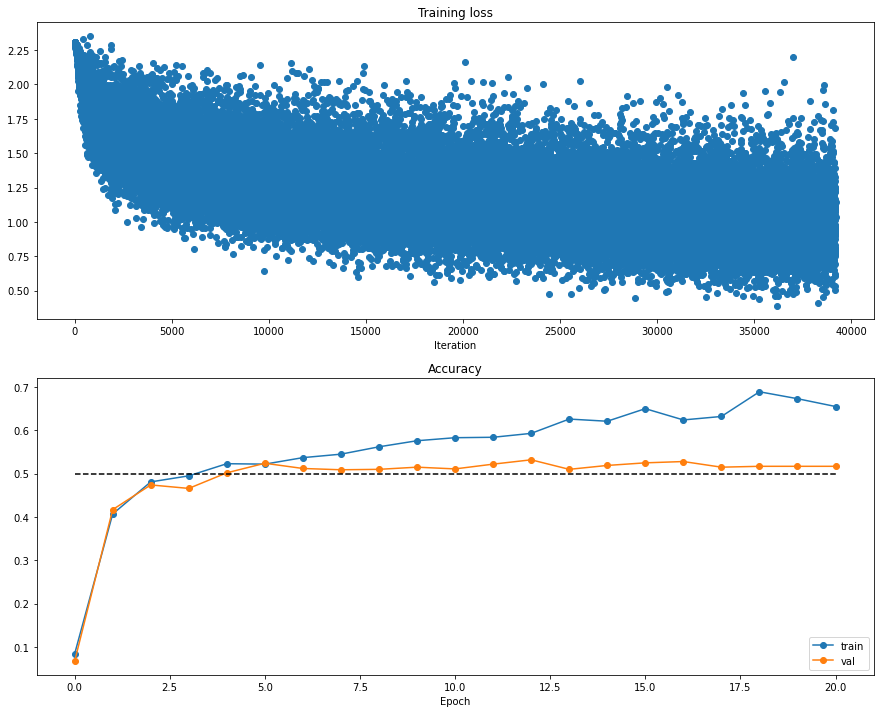

In [71]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch normalization; we will add those features soon.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-6 or less.

In [78]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 7.36e-09
W2 relative error: 6.87e-08
W3 relative error: 3.48e-08
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.80e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to tweak the learning rate and initialization scale, but you should be able to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 15.827254
(Epoch 0 / 20) train acc: 0.180000; val_acc: 0.111000
(Epoch 1 / 20) train acc: 0.280000; val_acc: 0.096000
(Epoch 2 / 20) train acc: 0.380000; val_acc: 0.114000
(Epoch 3 / 20) train acc: 0.560000; val_acc: 0.136000
(Epoch 4 / 20) train acc: 0.760000; val_acc: 0.146000
(Epoch 5 / 20) train acc: 0.900000; val_acc: 0.146000
(Iteration 11 / 40) loss: 0.846328
(Epoch 6 / 20) train acc: 0.960000; val_acc: 0.151000
(Epoch 7 / 20) train acc: 0.980000; val_acc: 0.154000
(Epoch 8 / 20) train acc: 1.000000; val_acc: 0.158000
(Epoch 9 / 20) train acc: 1.000000; val_acc: 0.157000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.155000
(Iteration 21 / 40) loss: 0.009417
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.157000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.157000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.157000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.154000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.157000
(Iteration 31 / 40) loss:

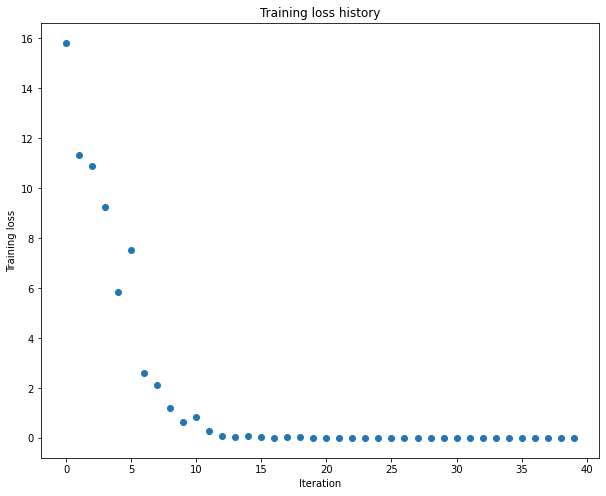

In [108]:
# TODO: Use a three-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 4e-2
learning_rate = 1e-3
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 13.656848
(Epoch 0 / 20) train acc: 0.120000; val_acc: 0.109000
(Epoch 1 / 20) train acc: 0.140000; val_acc: 0.103000
(Epoch 2 / 20) train acc: 0.360000; val_acc: 0.110000
(Epoch 3 / 20) train acc: 0.460000; val_acc: 0.110000
(Epoch 4 / 20) train acc: 0.560000; val_acc: 0.106000
(Epoch 5 / 20) train acc: 0.580000; val_acc: 0.117000
(Iteration 11 / 40) loss: 1.323247
(Epoch 6 / 20) train acc: 0.700000; val_acc: 0.112000
(Epoch 7 / 20) train acc: 0.820000; val_acc: 0.106000
(Epoch 8 / 20) train acc: 0.840000; val_acc: 0.111000
(Epoch 9 / 20) train acc: 0.860000; val_acc: 0.120000
(Epoch 10 / 20) train acc: 0.900000; val_acc: 0.111000
(Iteration 21 / 40) loss: 0.556820
(Epoch 11 / 20) train acc: 0.900000; val_acc: 0.111000
(Epoch 12 / 20) train acc: 0.940000; val_acc: 0.116000
(Epoch 13 / 20) train acc: 0.940000; val_acc: 0.111000
(Epoch 14 / 20) train acc: 0.960000; val_acc: 0.119000
(Epoch 15 / 20) train acc: 0.960000; val_acc: 0.117000
(Iteration 31 / 40) loss:

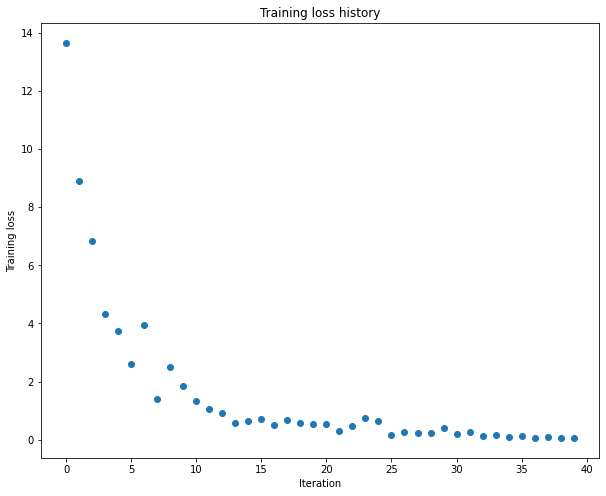

In [109]:
# TODO: Use a five-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 1e-3
weight_scale = 6e-2
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

# Inline question: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net?

# Answer:
Weight_scale for five-layer net is bigger than that for three-layer net. And as five-layer net initialize weights with higher weight scale, so it needs bigger learning rate.

# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than 1e-8.

In [83]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

running with  sgd
(Iteration 1 / 200) loss: 2.600441
(Epoch 0 / 5) train acc: 0.135000; val_acc: 0.144000
(Iteration 11 / 200) loss: 2.229292
(Iteration 21 / 200) loss: 2.143018
(Iteration 31 / 200) loss: 2.183328
(Epoch 1 / 5) train acc: 0.271000; val_acc: 0.270000
(Iteration 41 / 200) loss: 1.841863
(Iteration 51 / 200) loss: 1.909810
(Iteration 61 / 200) loss: 1.848698
(Iteration 71 / 200) loss: 1.868559
(Epoch 2 / 5) train acc: 0.377000; val_acc: 0.303000
(Iteration 81 / 200) loss: 1.774254
(Iteration 91 / 200) loss: 1.941549
(Iteration 101 / 200) loss: 1.886777
(Iteration 111 / 200) loss: 1.753916
(Epoch 3 / 5) train acc: 0.366000; val_acc: 0.300000
(Iteration 121 / 200) loss: 1.816913
(Iteration 131 / 200) loss: 1.655643
(Iteration 141 / 200) loss: 1.659777
(Iteration 151 / 200) loss: 1.743959
(Epoch 4 / 5) train acc: 0.441000; val_acc: 0.343000
(Iteration 161 / 200) loss: 1.569260
(Iteration 171 / 200) loss: 1.633934
(Iteration 181 / 200) loss: 1.620178
(Iteration 191 / 200) los

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

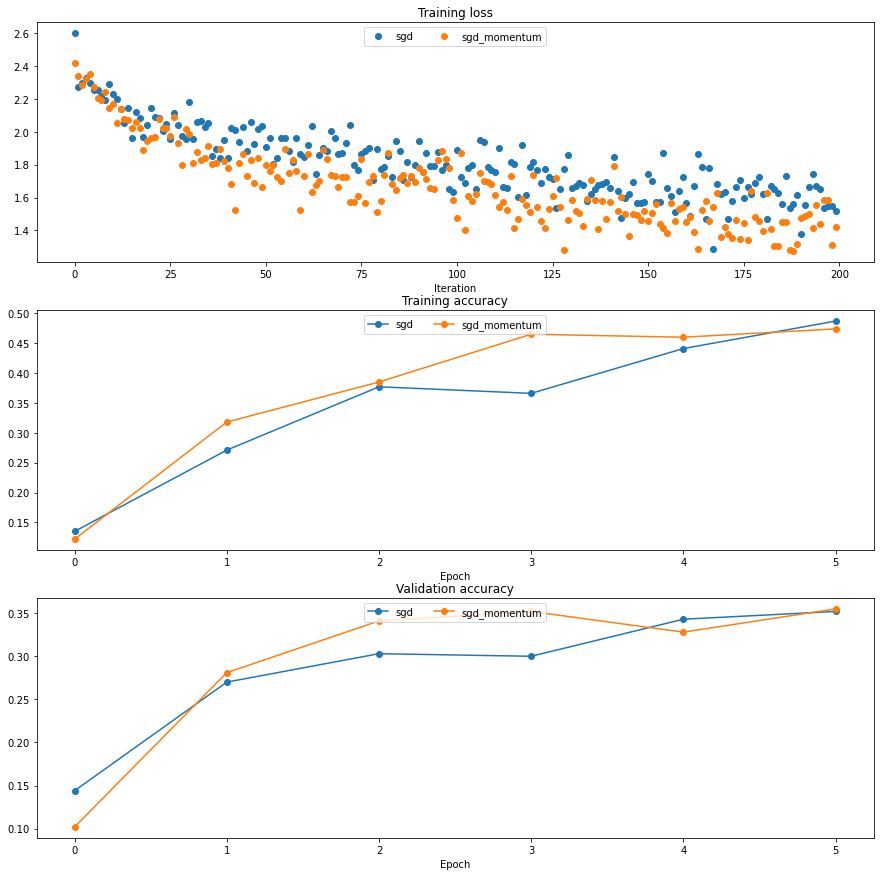

In [85]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [88]:
# Test RMSProp implementation; you should see errors less than 1e-7
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [90]:
# Test Adam implementation; you should see errors around 1e-7 or less
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

running with  adam
(Iteration 1 / 200) loss: 2.653412
(Epoch 0 / 5) train acc: 0.135000; val_acc: 0.105000
(Iteration 11 / 200) loss: 2.144123
(Iteration 21 / 200) loss: 1.950496
(Iteration 31 / 200) loss: 1.731374
(Epoch 1 / 5) train acc: 0.357000; val_acc: 0.309000
(Iteration 41 / 200) loss: 1.858646
(Iteration 51 / 200) loss: 1.902339
(Iteration 61 / 200) loss: 1.725642
(Iteration 71 / 200) loss: 1.557029
(Epoch 2 / 5) train acc: 0.458000; val_acc: 0.355000
(Iteration 81 / 200) loss: 1.602289
(Iteration 91 / 200) loss: 1.556743
(Iteration 101 / 200) loss: 1.578461
(Iteration 111 / 200) loss: 1.582299
(Epoch 3 / 5) train acc: 0.516000; val_acc: 0.359000
(Iteration 121 / 200) loss: 1.412785
(Iteration 131 / 200) loss: 1.331543
(Iteration 141 / 200) loss: 1.195586
(Iteration 151 / 200) loss: 1.284233
(Epoch 4 / 5) train acc: 0.551000; val_acc: 0.356000
(Iteration 161 / 200) loss: 1.477576
(Iteration 171 / 200) loss: 1.360925
(Iteration 181 / 200) loss: 1.235972
(Iteration 191 / 200) lo

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

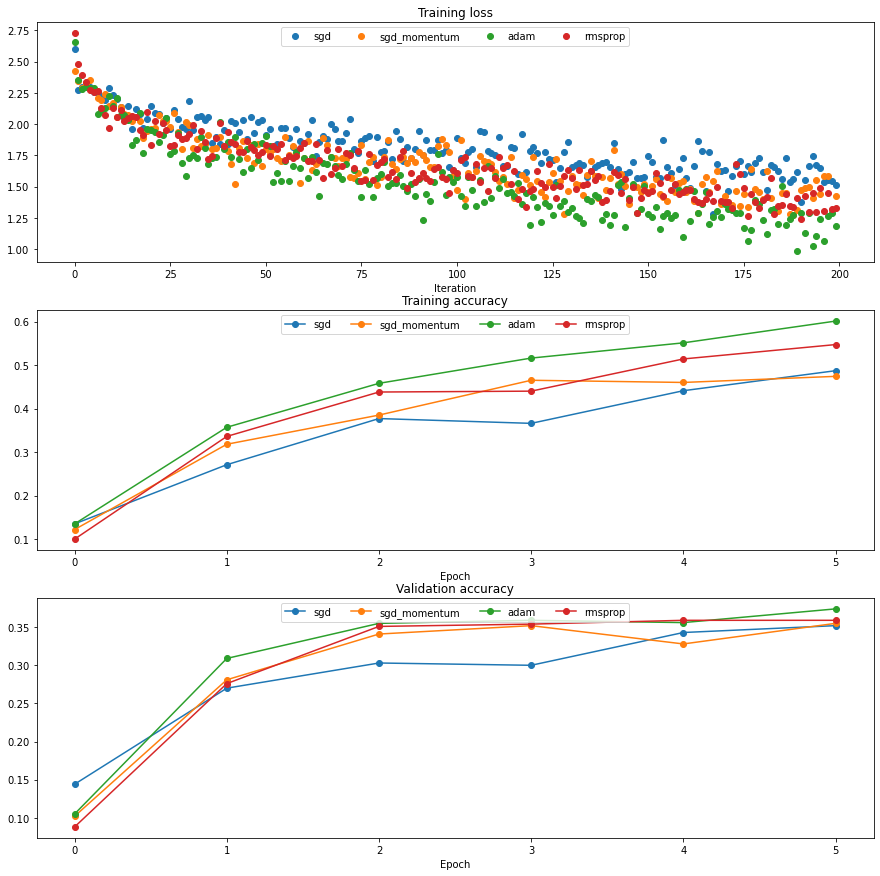

In [91]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [106]:
best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# batch normalization and dropout useful. Store your best model in the         #
# best_model variable.                                                         #
################################################################################

hidden_dims = [100] * 4
range_weight_scale = [1e-2, 7e-3]
range_lr = [1e-4, 5e-4]
use_batchnorm = True
dropout = [0, 0.1]

best_val_acc = -1
best_weight_scale = 0
best_lr = 0

print("Training...")

for weight_scale in range_weight_scale:
    for lr in range_lr:
        for p in dropout:
            print("weight_scale: %f, lr: %f, dropout: %f" % (weight_scale, lr, p))
            model = FullyConnectedNet(hidden_dims=hidden_dims, reg=0.0,
                                      weight_scale=weight_scale,
                                      use_batchnorm=use_batchnorm,
                                      dropout = p)
            solver = Solver(model, data, update_rule='adam',
                            optim_config={'learning_rate': lr},
                            batch_size=100, num_epochs=5,
                            verbose=False)
            solver.train()
            val_acc = solver.best_val_acc

            print('val_acc: %f' % (val_acc))

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_weight_scale = weight_scale
                best_lr = lr
                best_model = model

print("Best val_acc: %f" % best_val_acc)
print("Best weight_scale: %f" % best_weight_scale)
print("Best lr: %f" % best_lr)


################################################################################
#                              END OF YOUR CODE                                #
################################################################################

Training...
weight_scale: 0.010000, lr: 0.000100, dropout: 0.000000
val_acc: 0.543000
weight_scale: 0.010000, lr: 0.000100, dropout: 0.100000
val_acc: 0.530000
weight_scale: 0.010000, lr: 0.000500, dropout: 0.000000
val_acc: 0.547000
weight_scale: 0.010000, lr: 0.000500, dropout: 0.100000
val_acc: 0.521000
weight_scale: 0.007000, lr: 0.000100, dropout: 0.000000
val_acc: 0.556000
weight_scale: 0.007000, lr: 0.000100, dropout: 0.100000
val_acc: 0.520000
weight_scale: 0.007000, lr: 0.000500, dropout: 0.000000
val_acc: 0.543000
weight_scale: 0.007000, lr: 0.000500, dropout: 0.100000
val_acc: 0.517000
Best val_acc: 0.556000
Best weight_scale: 0.007000
Best lr: 0.000100


# Test you model
Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [107]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.556
Test set accuracy:  0.51
